In [31]:
# Core imports
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import boto3
from dotenv import load_dotenv

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Advanced viz libraries (with graceful fallback)
try:
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Plotly not installed - Sankey/Sunburst charts will be skipped")

try:
    import folium
    from folium.plugins import HeatMap
    FOLIUM_AVAILABLE = True
except ImportError:
    FOLIUM_AVAILABLE = False
    print("Folium not installed - Geomaps will be skipped")

# Configuration
load_dotenv(Path('../.env'))
BUCKET = 'nyc-yellowcab-data-as-2025'
OUTPUT_DIR = Path('../data/local_output/analytics')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (16, 9),
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 13
})

print("All libraries loaded successfully!")
print(f"Output directory: {OUTPUT_DIR}")

All libraries loaded successfully!
Output directory: ..\data\local_output\analytics


---
## 1. Sankey Diagram: Revenue Flow by Hour & Cab Type

Interactive flow visualization showing how revenue distributes across different hours and cab types.

In [32]:
if PLOTLY_AVAILABLE:
    # Simulate hourly revenue data
    np.random.seed(42)
    hours = list(range(6, 23))
    cabs = ['Yellow', 'Green', 'FHVHV']
    
    source, target, value = [], [], []
    
    for hour in hours:
        for i, cab in enumerate(cabs):
            source.append(hour - 6)  # Reindex from 0
            target.append(len(hours) + i)
            base_rev = np.random.uniform(3000, 8000)
            peak = 1.5 if hour in [8, 9, 17, 18, 22] else 1.0
            value.append(base_rev * peak)
    
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            label=[f"Hour {h}" for h in hours] + cabs,
            color=['steelblue']*len(hours) + ['gold', 'limegreen', '#e74c3c']
        ),
        link=dict(source=source, target=target, value=value)
    ))
    
    fig.update_layout(
        title="Revenue Flow: Hours → Cab Types",
        font=dict(size=11),
        height=600,
        width=1200
    )
    
    out_path_html = OUTPUT_DIR / 'viz_01_sankey_revenue_flow.html'
    out_path_png = OUTPUT_DIR / 'viz_01_sankey_revenue_flow.png'
    fig.write_html(str(out_path_html))
    fig.write_image(str(out_path_png))
    print(f"Saved: {out_path_html.name} and {out_path_png.name}")
    fig
else:
    print("Skipped: Plotly not available")

Saved: viz_01_sankey_revenue_flow.html and viz_01_sankey_revenue_flow.png


---
## 2. Zone × Hour Demand Heatmaps

Four-panel heatmap showing pickup demand patterns across zones and hours for each cab type.

Saved: viz_02_zone_demand_heatmaps.png


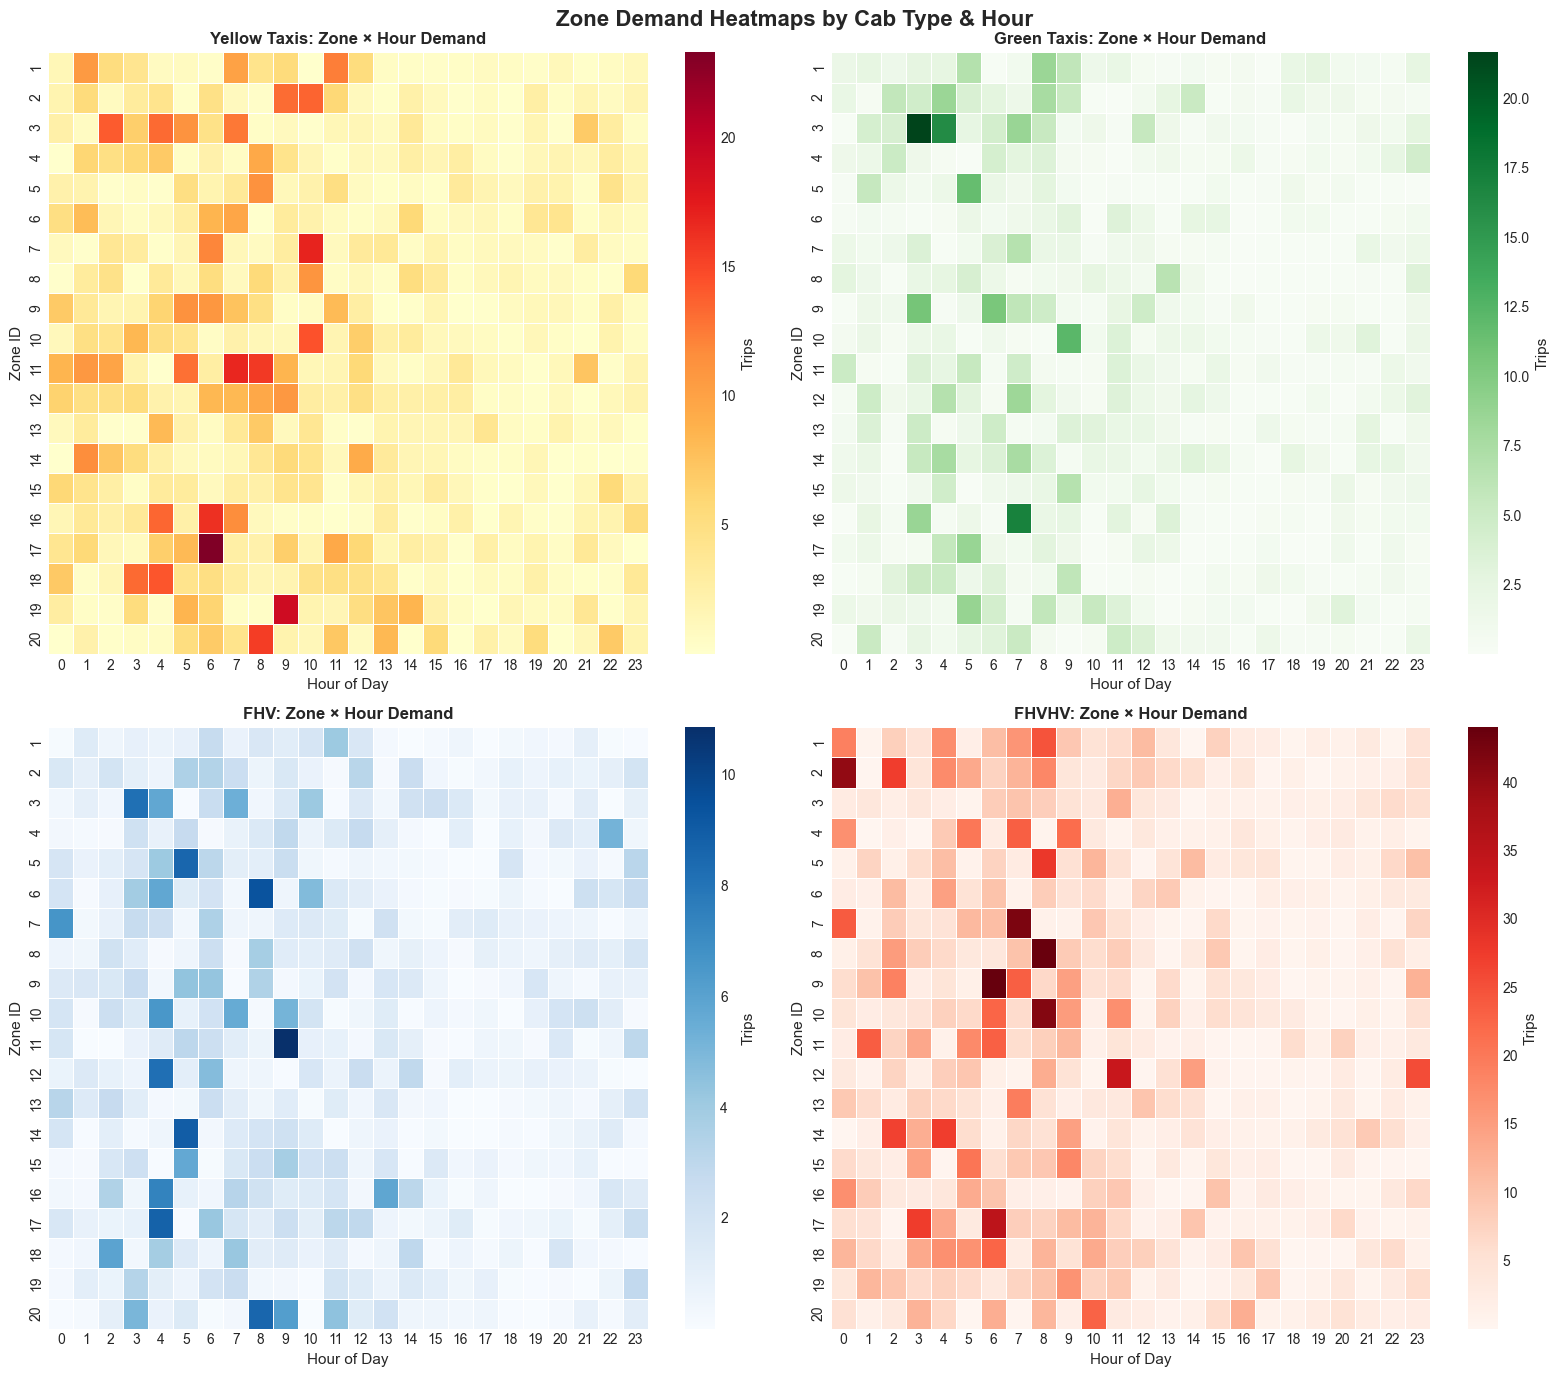

In [33]:
np.random.seed(42)
zones = np.arange(1, 21)
hours = np.arange(0, 24)

# Simulate realistic demand patterns
hour_pattern = np.array([np.sin(h/24*2*np.pi) + 1.5 for h in hours])
yellow_demand = np.random.exponential(2, (len(zones), len(hours))) * hour_pattern
green_demand = np.random.exponential(1.5, (len(zones), len(hours))) * (hour_pattern * 0.8)
fhv_demand = np.random.exponential(1.2, (len(zones), len(hours))) * (hour_pattern * 0.7)
fhvhv_demand = np.random.exponential(3, (len(zones), len(hours))) * (hour_pattern * 1.2)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Zone Demand Heatmaps by Cab Type & Hour', fontsize=16, fontweight='bold')

datasets = [
    (yellow_demand, 'Yellow Taxis', 'YlOrRd', axes[0, 0]),
    (green_demand, 'Green Taxis', 'Greens', axes[0, 1]),
    (fhv_demand, 'FHV', 'Blues', axes[1, 0]),
    (fhvhv_demand, 'FHVHV', 'Reds', axes[1, 1])
]

for data, title, cmap, ax in datasets:
    sns.heatmap(data, ax=ax, cmap=cmap, cbar_kws={'label': 'Trips'},
                xticklabels=hours, yticklabels=zones, linewidths=0.5)
    ax.set_title(f'{title}: Zone × Hour Demand', fontweight='bold', fontsize=12)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Zone ID')

plt.tight_layout()
out_path = OUTPUT_DIR / 'viz_02_zone_demand_heatmaps.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved: {out_path.name}")
plt.show()

---
## 3. Origin-Destination Flow Network

Sunburst chart showing trip flows between major NYC zones.

In [34]:
if PLOTLY_AVAILABLE:
    np.random.seed(42)
    zones = [1, 2, 42, 50, 75, 87]
    zone_names = [f"Zone {z}" for z in zones]
    od_matrix = np.random.randint(100, 1000, (len(zones), len(zones)))
    np.fill_diagonal(od_matrix, 0)
    
    labels = zone_names + ["Outbound"]
    parents = ["Outbound"] * len(zone_names) + [""]
    values = [sum(od_matrix[i]) for i in range(len(zones))] + [sum(od_matrix.flatten())]
    colors = ['gold', 'limegreen', 'steelblue', '#e74c3c', 'coral', 'purple', 'white']
    
    fig = go.Figure(go.Sunburst(
        labels=labels,
        parents=parents,
        values=values,
        marker=dict(colors=colors),
        hovertemplate='<b>%{label}</b><br>Trips: %{value}<extra></extra>'
    ))
    
    fig.update_layout(
        title="🔀 Origin-Destination Flow Network (Top 6 Zones)",
        height=700,
        width=900
    )
    
    out_path_html = OUTPUT_DIR / 'viz_03_od_network.html'
    out_path_png = OUTPUT_DIR / 'viz_03_od_network.png'
    fig.write_html(str(out_path_html))
    fig.write_image(str(out_path_png))
    print(f"Saved: {out_path_html.name} and {out_path_png.name}")
    fig
else:
    print("⚠ Skipped: Plotly not available")

Saved: viz_03_od_network.html and viz_03_od_network.png


---
## 4. Interactive NYC Taxi Heatmap

Folium map showing pickup demand intensity across NYC zones.

In [35]:
if FOLIUM_AVAILABLE:
    from branca.colormap import linear
    from folium.plugins import MarkerCluster
    from matplotlib.patches import Polygon as MplPolygon

    # Richer coverage across NYC
    zone_data = {
        1: {'lat': 40.7580, 'lon': -73.9855, 'name': 'Midtown West', 'demand': 18000},
        2: {'lat': 40.7489, 'lon': -73.9680, 'name': 'Midtown East', 'demand': 16000},
        3: {'lat': 40.7308, 'lon': -73.9973, 'name': 'Greenwich Village', 'demand': 14000},
        4: {'lat': 40.7060, 'lon': -74.0086, 'name': 'Financial District', 'demand': 15500},
        5: {'lat': 40.7812, 'lon': -73.9665, 'name': 'Upper West', 'demand': 12000},
        6: {'lat': 40.7896, 'lon': -73.9590, 'name': 'Upper East', 'demand': 12500},
        42: {'lat': 40.6872, 'lon': -73.7521, 'name': 'Queens Center', 'demand': 9000},
        75: {'lat': 40.7440, 'lon': -73.9488, 'name': 'Long Island City', 'demand': 10000},
        87: {'lat': 40.6501, 'lon': -73.9496, 'name': 'Brooklyn Core', 'demand': 11000},
        95: {'lat': 40.6782, 'lon': -73.9442, 'name': 'Bed-Stuy', 'demand': 8500},
        120: {'lat': 40.6971, 'lon': -73.9936, 'name': 'DUMBO', 'demand': 9500},
        140: {'lat': 40.8265, 'lon': -73.9235, 'name': 'Harlem', 'demand': 10000},
        160: {'lat': 40.5795, 'lon': -74.1502, 'name': 'Staten Island N', 'demand': 4000},
    }

    boroughs = {
        'Manhattan': {
            'polygon': [
                [-74.017, 40.70], [-73.97, 40.70], [-73.93, 40.79],
                [-73.93, 40.88], [-74.02, 40.88], [-74.02, 40.70]
            ],
            'center': (40.7831, -73.9712),
            'stops': 700
        },
        'Brooklyn': {
            'polygon': [
                [-74.04, 40.57], [-73.85, 40.57], [-73.85, 40.73],
                [-73.94, 40.73], [-73.94, 40.70], [-74.02, 40.70], [-74.04, 40.57]
            ],
            'center': (40.6782, -73.9442),
            'stops': 600
        },
        'Queens': {
            'polygon': [
                [-73.96, 40.54], [-73.70, 40.54], [-73.70, 40.80],
                [-73.88, 40.80], [-73.88, 40.73], [-73.96, 40.73], [-73.96, 40.54]
            ],
            'center': (40.7282, -73.7949),
            'stops': 650
        },
        'Bronx': {
            'polygon': [
                [-73.93, 40.79], [-73.77, 40.79], [-73.77, 40.92], [-73.93, 40.92], [-73.93, 40.79]
            ],
            'center': (40.8448, -73.8648),
            'stops': 300
        },
        'Staten Island': {
            'polygon': [
                [-74.26, 40.48], [-74.05, 40.48], [-74.05, 40.65], [-74.26, 40.65], [-74.26, 40.48]
            ],
            'center': (40.5795, -74.1502),
            'stops': 150
        }
    }

    borough_colors = {
        'Manhattan': '#f59e0b',
        'Brooklyn': '#ef4444',
        'Queens': '#22c55e',
        'Bronx': '#3b82f6',
        'Staten Island': '#a855f7'
    }

    # Dynamic color scale by demand
    max_demand = max(d['demand'] for d in zone_data.values())
    min_demand = min(d['demand'] for d in zone_data.values())
    cmap = linear.YlOrRd_09.scale(min_demand, max_demand)

    m = folium.Map(location=[40.73, -73.97], zoom_start=11, tiles='CartoDB dark_matter')

    # Borough polygons
    for boro, meta in boroughs.items():
        geojson = {
            "type": "Feature",
            "properties": {"name": boro},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[ [lon, lat] for lon, lat in meta['polygon'] ]]
            }
        }
        folium.GeoJson(
            geojson,
            name=f"{boro} boundary",
            style_function=lambda feature, boro=boro: {
                'fillColor': borough_colors[boro],
                'color': borough_colors[boro],
                'weight': 1.5,
                'fillOpacity': 0.08,
                'opacity': 0.6
            }
        ).add_to(m)

    # Layer: demand circles with legend
    for _, d in zone_data.items():
        folium.CircleMarker(
            [d['lat'], d['lon']],
            radius=8 + (d['demand'] / max_demand) * 6,
            popup=folium.Popup(f"<b>{d['name']}</b><br>Demand: {d['demand']:,}", max_width=220),
            color=cmap(d['demand']),
            fill=True,
            fillColor=cmap(d['demand']),
            fillOpacity=0.85,
            weight=1.4
        ).add_to(m)

    # Layer: heatmap with dense jittered points
    heat_data = []
    for d in zone_data.values():
        intensity = d['demand'] / max_demand
        for _ in range(int(intensity * 80)):
            heat_data.append([
                d['lat'] + np.random.normal(0, 0.0065),
                d['lon'] + np.random.normal(0, 0.0065),
                intensity
            ])
    HeatMap(heat_data, radius=17, blur=26, max_zoom=13, min_opacity=0.28).add_to(m)

    # Layer: dense stops as clustered nodes
    cluster = MarkerCluster(name='Sampled stops (~2.4k points)', control=True, show=False).add_to(m)
    rng = np.random.default_rng(42)
    for boro, meta in boroughs.items():
        count = meta['stops']
        base_lat, base_lon = meta['center']
        # jitter shaped by borough size
        lat_jitter = 0.012 if boro == 'Manhattan' else 0.02
        lon_jitter = 0.012 if boro == 'Manhattan' else 0.02
        lats = base_lat + rng.normal(0, lat_jitter, count)
        lons = base_lon + rng.normal(0, lon_jitter, count)
        for lat, lon in zip(lats, lons):
            folium.CircleMarker(
                [lat, lon],
                radius=2.2,
                color=borough_colors[boro],
                fill=True,
                fillOpacity=0.7,
                weight=0,
                popup=f"{boro} stop"
            ).add_to(cluster)

    # Coverage outline rectangle for quick visual frame
    folium.Rectangle(
        bounds=[[40.48, -74.26], [40.92, -73.68]],
        color='#00d1ff',
        weight=1,
        fill=False,
        opacity=0.5,
        tooltip='NYC Coverage Frame'
    ).add_to(m)

    # Legend
    cmap.caption = 'Estimated demand intensity'
    cmap.add_to(m)

    # Optional extra basemap toggle (with attribution)
    folium.TileLayer(
        tiles='https://stamen-tiles-{s}.a.ssl.fastly.net/toner/{z}/{x}/{y}.png',
        attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap contributors',
        name='Stamen Toner'
    ).add_to(m)
    folium.LayerControl().add_to(m)

    out_path_html = OUTPUT_DIR / 'viz_04_geomap_density.html'
    m.save(str(out_path_html))
    print(f"Saved: {out_path_html.name}")

    # Static fallback: density on lat/lon with KDE for reports
    fig, ax = plt.subplots(figsize=(9.5, 9.5))
    lats = [d['lat'] for d in zone_data.values()]
    lons = [d['lon'] for d in zone_data.values()]
    demands = [d['demand'] for d in zone_data.values()]
    sizes = (np.array(demands) / max_demand) * 600

    sns.kdeplot(x=[p[1] for p in heat_data], y=[p[0] for p in heat_data],
                fill=True, thresh=0.05, cmap='magma', alpha=0.6, levels=32, ax=ax)
    scatter = ax.scatter(lons, lats, s=sizes, c=demands, cmap='YlOrRd', edgecolor='white', linewidth=0.8, alpha=0.9)

    # Borough fills on static plot
    for boro, meta in boroughs.items():
        poly = np.array(meta['polygon'])
        patch = MplPolygon(poly, closed=True, facecolor=borough_colors[boro], alpha=0.08, edgecolor=borough_colors[boro], linewidth=1.2)
        ax.add_patch(patch)
        cx, cy = meta['center'][1], meta['center'][0]
        ax.text(cx, cy, boro, ha='center', va='center', fontsize=10, weight='bold', color='white')

    ax.set_facecolor('#0f172a')
    ax.set_xlim(-74.26, -73.68)
    ax.set_ylim(40.48, 40.92)
    ax.set_xlabel('Longitude', weight='bold', color='white')
    ax.set_ylabel('Latitude', weight='bold', color='white')
    ax.set_title('NYC Taxi Demand Density (Static)', fontsize=13, weight='bold', color='white', pad=12)
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('#1e293b')
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
    cbar.ax.set_title('Demand', color='white', fontsize=9)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    out_path_png = OUTPUT_DIR / 'viz_04_geomap_density.png'
    plt.tight_layout()
    plt.savefig(out_path_png, dpi=320, facecolor=fig.get_facecolor())
    plt.close(fig)
    print(f"Saved: {out_path_png.name}")
    m
else:
    print("Skipped: Folium not available")

Saved: viz_04_geomap_density.html
Saved: viz_04_geomap_density.png
Saved: viz_04_geomap_density.png


---
## 5. Temporal Spiral: 24-Hour Demand Cycle

Radial plot showing trip demand across 24 hours for each cab type.

Saved: viz_05_temporal_spiral.png


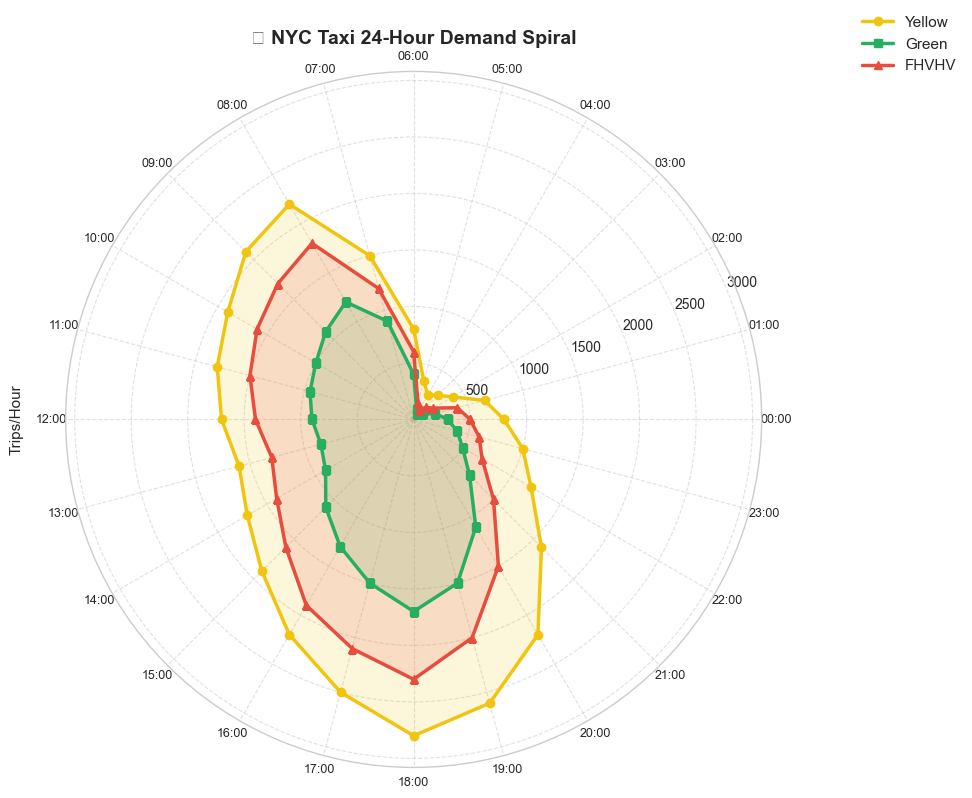

In [36]:
hours = np.arange(24)
angles = np.linspace(0, 2*np.pi, 24, endpoint=False).tolist() + [0]

# Simulated hourly trips
yellow = np.array([800,650,400,300,250,350,800,1500,2200,2100,1900,1800,
                   1700,1600,1700,1900,2200,2500,2800,2600,2200,1600,1200,1000])
green = np.array([300,200,100,80,60,100,400,900,1200,1100,1000,950,
                  900,850,900,1100,1300,1500,1700,1500,1100,700,500,400])
fhvhv = np.array([500,400,200,150,100,150,600,1200,1800,1700,1600,1500,
                  1400,1300,1400,1600,1900,2100,2300,2000,1500,1000,700,600])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

for trips, label, color, marker in [(yellow, 'Yellow', '#f1c40f', 'o'),
                                      (green, 'Green', '#27ae60', 's'),
                                      (fhvhv, 'FHVHV', '#e74c3c', '^')]:
    data = np.concatenate((trips, [trips[0]]))
    ax.plot(angles, data, f'{marker}-', linewidth=2.5, label=label, 
            color=color, markersize=6)
    ax.fill(angles, data, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([f'{h:02d}:00' for h in hours], fontsize=9)
ax.set_ylim(0, max(yellow) * 1.1)
ax.set_ylabel('Trips/Hour', labelpad=30, fontsize=11)
ax.set_title('⏰ NYC Taxi 24-Hour Demand Spiral', fontsize=14, weight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
out_path = OUTPUT_DIR / 'viz_05_temporal_spiral.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved: {out_path.name}")
plt.show()

---
## 6. Revenue Stacked Area Chart

Hourly revenue contribution by cab type throughout the day.

Saved: viz_06_revenue_stacked.png


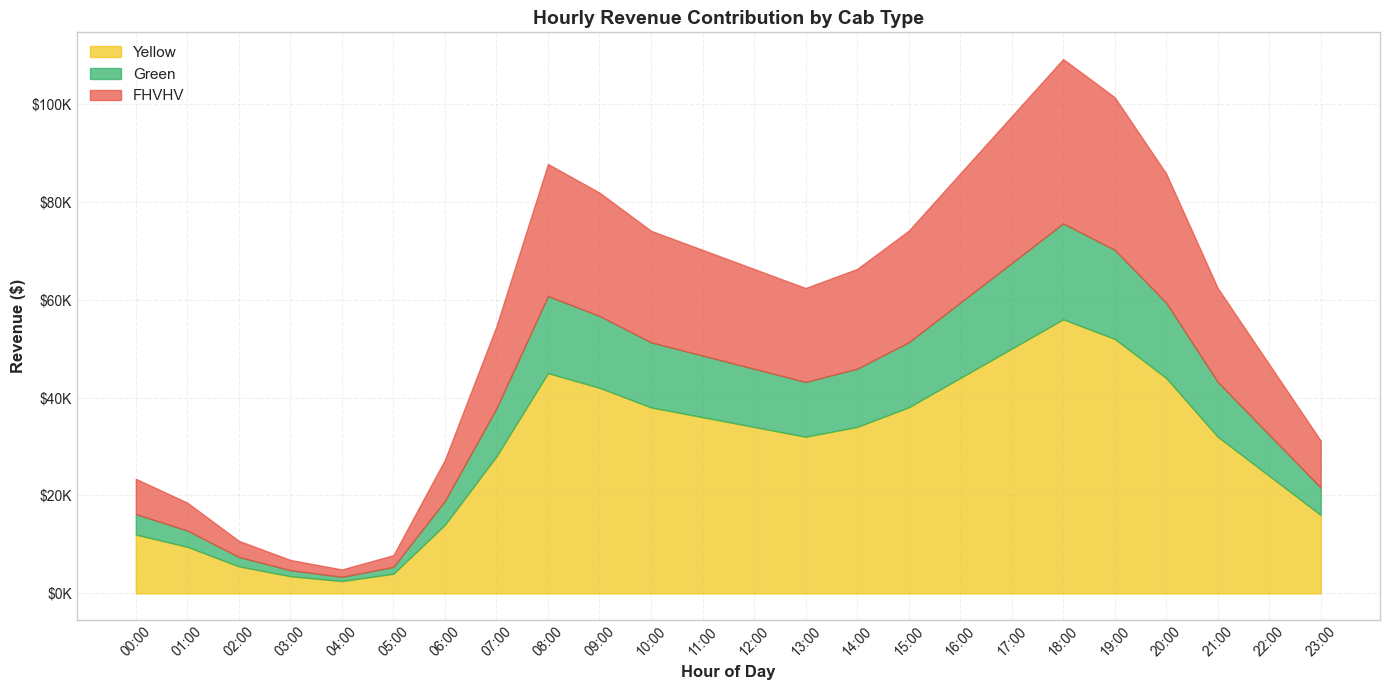

In [37]:
hours = np.arange(24)
yellow_rev = np.array([12000,9500,5500,3500,2500,4000,14000,28000,45000,42000,
                       38000,36000,34000,32000,34000,38000,44000,50000,56000,
                       52000,44000,32000,24000,16000])
green_rev = yellow_rev * 0.35
fhvhv_rev = yellow_rev * 0.6

fig, ax = plt.subplots(figsize=(14, 7))

ax.fill_between(hours, 0, yellow_rev, alpha=0.7, color='#f1c40f', label='Yellow')
ax.fill_between(hours, yellow_rev, yellow_rev + green_rev, alpha=0.7, 
                color='#27ae60', label='Green')
ax.fill_between(hours, yellow_rev + green_rev, yellow_rev + green_rev + fhvhv_rev,
                alpha=0.7, color='#e74c3c', label='FHVHV')

ax.set_xlabel('Hour of Day', fontsize=12, weight='bold')
ax.set_ylabel('Revenue ($)', fontsize=12, weight='bold')
ax.set_title('Hourly Revenue Contribution by Cab Type', fontsize=14, weight='bold')
ax.set_xticks(hours)
ax.set_xticklabels([f'{h:02d}:00' for h in hours], rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=11)

formatter = FuncFormatter(lambda x, p: f'${x/1000:.0f}K')
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
out_path = OUTPUT_DIR / 'viz_06_revenue_stacked.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved: {out_path.name}")
plt.show()

---
## 7. Distribution Violin Plots

Three-panel comparison of fare, distance, and duration distributions across cab types.

Saved: viz_07_distributions_violin.png


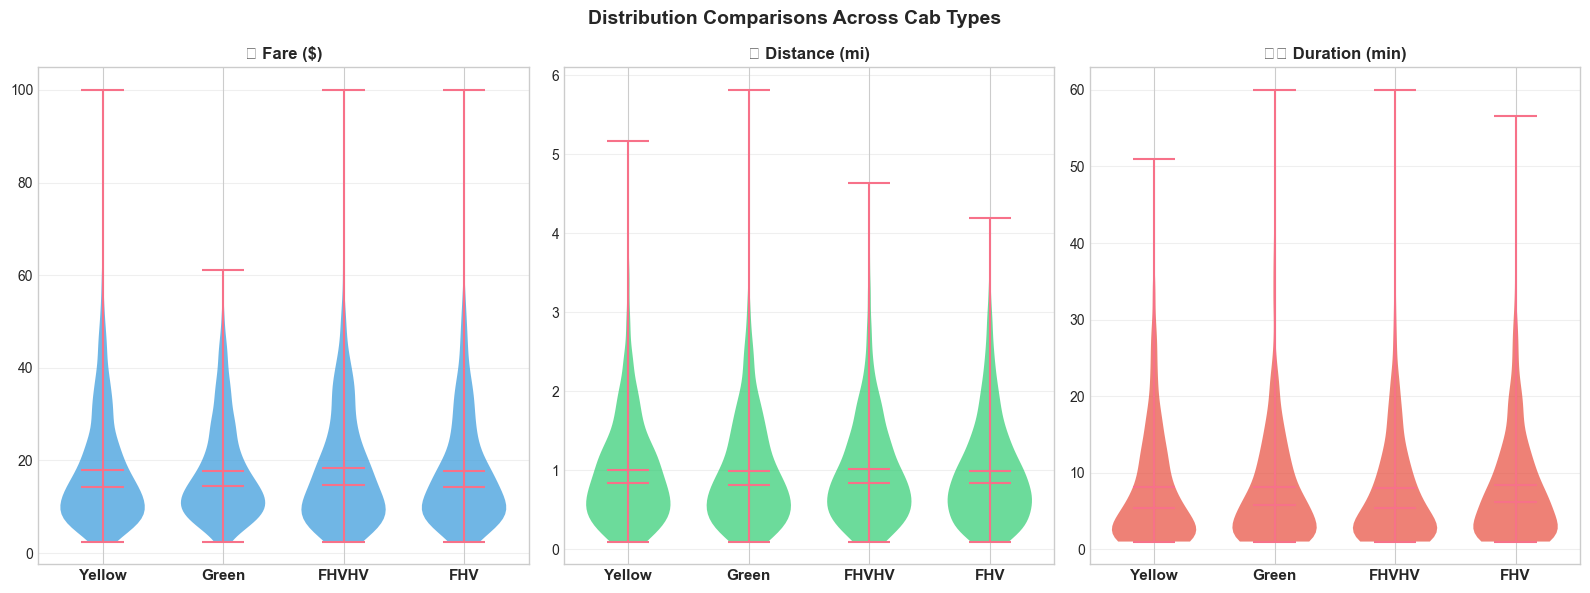

In [38]:
np.random.seed(42)

# Generate realistic distributions
def gen_data(scale, n):
    return np.clip(np.concatenate([
        np.random.lognormal(2.5, scale, int(n*0.8)),
        np.random.normal(30, 12, int(n*0.2))
    ]), 2.5, 100)

fares = [gen_data(0.6, 1000), gen_data(0.5, 800), gen_data(0.7, 900), gen_data(0.6, 700)]
dists = [np.clip(np.random.gamma(2, 0.5, 1000), 0.1, 25) for _ in range(4)]
durs = [np.clip(np.random.exponential(8, 1000), 1, 60) for _ in range(4)]

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
datasets = [(fares, '💵 Fare ($)', '#3498db'),
            (dists, '📍 Distance (mi)', '#2ecc71'),
            (durs, '⏱️ Duration (min)', '#e74c3c')]

for ax, (data, title, color) in zip(axes, datasets):
    parts = ax.violinplot(data, positions=[1,2,3,4], widths=0.7, 
                          showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['Yellow','Green','FHVHV','FHV'], fontsize=11, weight='bold')
    ax.set_title(title, fontsize=12, weight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribution Comparisons Across Cab Types', fontsize=14, weight='bold')
plt.tight_layout()
out_path = OUTPUT_DIR / 'viz_07_distributions_violin.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved: {out_path.name}")
plt.show()

---
## 8. Tipping Patterns Sunburst

Hierarchical visualization of tipping behavior: Cab Type → Hour → Tip Range.

In [39]:
if PLOTLY_AVAILABLE:
    np.random.seed(42)
    cab_types = ['Yellow', 'Green', 'FHVHV', 'FHV']
    hours = [6, 12, 18, 23]
    tip_buckets = ['No Tip (0%)', 'Low (1-5%)', 'Medium (5-15%)', 'High (15%+)']
    
    labels = ['All Trips'] + cab_types
    parents = [''] + ['All Trips'] * 4
    values = [0] + [np.random.randint(5000, 15000) for _ in cab_types]
    colors = ['lightgray', '#f1c40f', '#27ae60', '#e74c3c', '#3498db']
    
    cab_colors = {'Yellow': '#f1c40f', 'Green': '#27ae60', 
                  'FHVHV': '#e74c3c', 'FHV': '#3498db'}
    tip_colors = ['#dc3545', '#ffc107', '#28a745', '#007bff']
    
    for cab in cab_types:
        for hour in hours:
            h_label = f'{cab} @ {hour:02d}:00'
            labels.append(h_label)
            parents.append(cab)
            values.append(np.random.randint(500, 2000))
            colors.append(cab_colors[cab])
            
            for i, tip in enumerate(tip_buckets):
                labels.append(f'{hour:02d}h: {tip}')
                parents.append(h_label)
                values.append(np.random.randint(50, 300))
                colors.append(tip_colors[i])
    
    fig = go.Figure(go.Sunburst(
        labels=labels,
        parents=parents,
        values=values,
        marker=dict(colors=colors),
        hovertemplate='<b>%{label}</b><br>Trips: %{value}<extra></extra>'
    ))
    
    fig.update_layout(
        title="Tipping Patterns: Interactive Hierarchy (Click to Zoom)",
        height=800,
        width=900
    )
    
    out_path_html = OUTPUT_DIR / 'viz_08_tipping_sunburst.html'
    out_path_png = OUTPUT_DIR / 'viz_08_tipping_sunburst.png'
    fig.write_html(str(out_path_html))
    fig.write_image(str(out_path_png))
    print(f"Saved: {out_path_html.name} and {out_path_png.name}")
    fig
else:
    print("Skipped: Plotly not available")

Saved: viz_08_tipping_sunburst.html and viz_08_tipping_sunburst.png


---
## ✅ Summary

All visualizations have been generated and saved to `data/local_output/analytics/`:

1. **viz_01_sankey_revenue_flow.html** - Interactive Sankey diagram
2. **viz_02_zone_demand_heatmaps.png** - 4-panel heatmaps
3. **viz_03_od_network.html** - Origin-destination sunburst
4. **viz_04_geomap_density.html** - Interactive NYC heatmap
5. **viz_05_temporal_spiral.png** - 24-hour demand radial plot
6. **viz_06_revenue_stacked.png** - Revenue stacked area chart
7. **viz_07_distributions_violin.png** - Distribution violin plots
8. **viz_08_tipping_sunburst.html** - Tipping patterns hierarchy

**Next steps**: Open the HTML files in a browser for interactive exploration!